https://github.com/zhangxu0307/time_series_forecasting_pytorch

In [58]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import pandas as pd
import matplotlib.pyplot as plt

# Load Data

In [3]:
df = pd.read_csv('./obsmat.txt', sep = '  ', header = None)

/Users/emmasun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
df.head()

,0,1,2,3,4,5,6,7
0,780.0,1.0,8.456844,0.0,3.588066,1.671714,0.0,0.176292
1,786.0,1.0,9.125530,0.0,3.658583,1.662877,0.0,0.326723
2,792.0,1.0,9.787146,0.0,3.849445,1.683334,0.0,0.371084
3,798.0,1.0,10.472197,0.0,3.955450,1.598568,0.0,0.264795
4,804.0,1.0,11.066000,0.0,4.061280,1.574526,0.0,0.456390


In [5]:
df.columns = ["frame_number", "pedestrian_ID", "pos_x", "pos_z", "pos_y", "v_x", "v_z", "v_y"]

In [6]:
groupby_report = df.groupby(['pedestrian_ID']).size().reset_index(name='counts')
groupby_report

,pedestrian_ID,counts
0,1.0,7
1,2.0,37
2,3.0,32
3,4.0,24
4,5.0,24
5,6.0,30
6,7.0,16
7,8.0,31
8,9.0,10
9,10.0,10


In [8]:
groupby_report['counts'].describe()

count    360.000000
mean      24.744444
std       13.590970
min        2.000000
25%       20.000000
50%       24.000000
75%       28.000000
max      190.000000
Name: counts, dtype: float64

In [9]:
print(groupby_report.counts.quantile(0.1)) 
print(groupby_report.counts.quantile(0.3)) 
print(groupby_report.counts.quantile(0.85)) 

13.0
21.700000000000003
31.0


In [10]:
threshold_frames = 13
groupby_report_cropped = groupby_report[groupby_report.counts>=threshold_frames]
groupby_report_cropped

,pedestrian_ID,counts
1,2.0,37
2,3.0,32
3,4.0,24
4,5.0,24
5,6.0,30
6,7.0,16
7,8.0,31
10,11.0,33
11,12.0,33
12,13.0,30


In [12]:
data_clean = df[df.pedestrian_ID.isin(groupby_report_cropped.pedestrian_ID) ]
data_clean

,frame_number,pedestrian_ID,pos_x,pos_z,pos_y,v_x,v_z,v_y
5,804.0,2.0,13.017548,0.0,5.782591,-2.324444,0.0,-0.076606
7,810.0,2.0,12.087770,0.0,5.751949,-1.589052,0.0,-0.065971
9,816.0,2.0,11.746306,0.0,5.729815,-1.140766,0.0,0.105373
10,822.0,2.0,11.175158,0.0,5.836247,-1.640021,0.0,0.179235
11,828.0,2.0,10.434290,0.0,5.873203,-1.406129,0.0,0.419050
12,834.0,3.0,12.270674,0.0,6.668422,-0.835892,0.0,0.245535
13,834.0,2.0,10.050254,0.0,6.171487,-1.078742,0.0,0.455190
14,840.0,3.0,11.936317,0.0,6.766636,-1.028251,0.0,0.307482
15,840.0,2.0,9.571296,0.0,6.237355,-1.207725,0.0,0.115437
16,846.0,5.0,-1.886113,0.0,4.379495,1.510261,0.0,0.196705


In [13]:
data_clean['frame_count'] = data_clean.groupby(['pedestrian_ID']).cumcount()+1
data_clean = data_clean[data_clean.frame_count<=13]
data_clean.sort_values(['pedestrian_ID', 'frame_number'], ascending=[True, True],inplace=True)
data_clean

/Users/emmasun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/emmasun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,frame_number,pedestrian_ID,pos_x,pos_z,pos_y,v_x,v_z,v_y,frame_count
5,804.0,2.0,13.017548,0.0,5.782591,-2.324444,0.0,-0.076606,1
7,810.0,2.0,12.087770,0.0,5.751949,-1.589052,0.0,-0.065971,2
9,816.0,2.0,11.746306,0.0,5.729815,-1.140766,0.0,0.105373,3
10,822.0,2.0,11.175158,0.0,5.836247,-1.640021,0.0,0.179235,4
11,828.0,2.0,10.434290,0.0,5.873203,-1.406129,0.0,0.419050,5
13,834.0,2.0,10.050254,0.0,6.171487,-1.078742,0.0,0.455190,6
15,840.0,2.0,9.571296,0.0,6.237355,-1.207725,0.0,0.115437,7
19,846.0,2.0,9.084074,0.0,6.263836,-1.273181,0.0,0.170841,8
24,852.0,2.0,8.552751,0.0,6.374027,-1.232733,0.0,0.271502,9
29,858.0,2.0,8.097887,0.0,6.481037,-1.146730,0.0,0.217892,10


In [16]:
data_clean['pedestrian_ID'].nunique()

328

In [105]:
data_clean_features = data_clean[data_clean['frame_count'] != 13][['pos_x', 'pos_y']].values
data_clean_targets = data_clean[data_clean['frame_count'] == 13][['pos_x', 'pos_y']].values
data_clean_features_reshape = data_clean_features.reshape(328, 12, 2)
data_clean_targets_reshape = data_clean_targets.reshape(328, 2)
# train 
X_train = data_clean_features_reshape[1:230]
print(X_train.shape)
Y_train = data_clean_targets_reshape[1:230]
print(Y_train.shape)

# test
X_test = data_clean_features_reshape[230:]
print(X_test.shape)
Y_test = data_clean_targets_reshape[230:]
print(Y_test.shape)

(229, 12, 2)
(229, 2)
(98, 12, 2)
(98, 2)


In [106]:
# cast into float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')

# RNN

In [46]:
from torch.utils.data import Dataset
class Time_Series_Data(Dataset):

    def __init__(self, train_x, train_y):
        self.X = train_x
        self.y = train_y

    def __getitem__(self, item):
        x_t = self.X[item]
        y_t = self.y[item]
        return x_t, y_t

    def __len__(self):

        return len(self.X)


In [42]:
# RNNs模型基类，主要是用于指定参数和cell类型
class BaseModel(nn.Module):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda=False):

        super(BaseModel, self).__init__()
        self.hiddenNum = hiddenNum
        self.inputDim = inputDim
        self.outputDim = outputDim
        self.layerNum = layerNum
        self.use_cuda = use_cuda
        if cell == "RNN":
            self.cell = nn.RNN(input_size=self.inputDim, hidden_size=self.hiddenNum,
                        num_layers=self.layerNum, dropout=0.0,
                         nonlinearity="tanh", batch_first=True,)
        if cell == "LSTM":
            self.cell = nn.LSTM(input_size=self.inputDim, hidden_size=self.hiddenNum,
                               num_layers=self.layerNum, dropout=0.0,
                               batch_first=True, )
        if cell == "GRU":
            self.cell = nn.GRU(input_size=self.inputDim, hidden_size=self.hiddenNum,
                                num_layers=self.layerNum, dropout=0.0,
                                 batch_first=True, )
        print(self.cell)
        #fc - fully connected
        self.fc = nn.Linear(self.hiddenNum, self.outputDim) #arg: size of input sample, size of output sample
        #the above are setups, these parameters are different from the ones passed in below

# 标准RNN模型
class RNNModel(BaseModel):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda):

        super(RNNModel, self).__init__(inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda)
        
    #most confused here about the dimensions
    def forward(self, x):
        
        batchSize = x.size(0) #x.dim1 is batchsize 32, x's dim2 should be time series sequence length 24. x(32,24)

        h0 = Variable(torch.zeros(self.layerNum * 1, batchSize , self.hiddenNum)) #variable includes backward calc arg
        #so it is a 3D - for each layer, each batchsize, each hidden neuron
        if self.use_cuda:
            h0 = h0.cuda()
        rnnOutput, hn = self.cell(x, h0) #?pass in x and a 3D zero tensor? (1,32,64) as h0 input
        hn = hn.view(batchSize, self.hiddenNum)  #(32,64)
        fcOutput = self.fc(hn) #pass in hidden layer to give linear estimation

        return fcOutput

In [126]:
# LSTM模型
class LSTMModel(BaseModel):

    def __init__(self, inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda):
        super(LSTMModel, self).__init__(inputDim, hiddenNum, outputDim, layerNum, cell, use_cuda)

    def forward(self, x):

        batchSize = x.size(0)
        h0 = Variable(torch.zeros(self.layerNum * 1, batchSize, self.hiddenNum))
        c0 = Variable(torch.zeros(self.layerNum * 1, batchSize, self.hiddenNum))
        if self.use_cuda:
            h0 = h0.cuda()
            c0 = c0.cuda()
        rnnOutput, hn = self.cell(x, (h0, c0))
        hn = hn[0].view(batchSize, self.hiddenNum)
        fcOutput = self.fc(hn)

        return fcOutput

In [124]:
def train(trainX, trainY,  lag, lr, method, hidden_num=64, epoch=20, batchSize=32,
           checkPoint=10, use_cuda=False): #hidden_num here is 64, what kind of dimension is this?

    print('here')
    lossList = []

    # build up data loader
    dataset = Time_Series_Data(trainX, trainY)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, sampler=None,
                                             batch_sampler=None, num_workers=1)
    net = None
    if method == "RNN": #seems these dim means number of neurons not the dimension of data
        net = RNNModel(inputDim=2, hiddenNum=hidden_num, outputDim=2, layerNum=1, cell="RNN", use_cuda=use_cuda)
    if method == "LSTM":
        net = LSTMModel(inputDim=2, hiddenNum=hidden_num, outputDim=2, layerNum=1, cell="LSTM", use_cuda=use_cuda)
    if method == "GRU":
        net = GRUModel(inputDim=2, hiddenNum=hidden_num, outputDim=2, layerNum=1, cell="GRU", use_cuda=use_cuda)
    if method == "ResRNN":
        net = ResRNNModel(inputDim=2, hiddenNum=hidden_num, outputDim=2, resDepth=4, use_cuda=use_cuda)
    # if method == "attention":
    #     net = RNN_Attention(inputDim=1, hiddenNum=hidden_num, outputDim=1, resDepth=4,
    #                         seq_len=lag, merge="concate", use_cuda=use_cuda)
    if method == "MLP":
        net = MLPModel(inputDim=lag, hiddenNum=hidden_num, outputDim=1)
    if use_cuda:
        net = net.cuda()
    net = net.train() #just to let the function know you are training the model.
    #So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.
    optimizer = optim.RMSprop(net.parameters(), lr=lr, momentum=0.9)
    criterion = nn.MSELoss()

    t1 = time.time()
    lossSum = 0

    print("data loader num:", len(dataloader))

    for i in range(epoch):

        for batch_idx, (x, y) in enumerate(dataloader):
            #set them into variables so that their backpropagation is on
            x, y = Variable(x), Variable(y)
            if use_cuda:
                x = x.cuda()
                y = y.cuda()

            optimizer.zero_grad()

            pred = net.forward(x)
            loss = criterion(pred, y)

            lossSum += loss.item()
            if batch_idx % checkPoint == 0 and batch_idx != 0:
               print("batch: %d , loss is:%f" % (batch_idx, lossSum / checkPoint))
               lossList.append(lossSum / checkPoint)
               lossSum = 0

            loss.backward()
            optimizer.step()

        print("%d epoch is finished!" % (i+1))

    t2 = time.time()
    print("train time:", t2-t1)
    #p.dump(lossList, output, -1)

    return net


In [107]:
# trainX needs to be 3D array (non tensor), float32
trained_RNN = train(X_train, Y_train, 12 , 1e-3 , 'RNN', hidden_num=30, epoch=20, batchSize=8,checkPoint=10, use_cuda=False) 

here
RNN(2, 30, batch_first=True)
data loader num: 29
batch: 10 , loss is:18.437079
batch: 20 , loss is:13.677203
1 epoch is finished!
batch: 10 , loss is:9.613804
batch: 20 , loss is:3.751985
2 epoch is finished!
batch: 10 , loss is:4.033877
batch: 20 , loss is:1.204307
3 epoch is finished!
batch: 10 , loss is:2.551998
batch: 20 , loss is:1.059414
4 epoch is finished!
batch: 10 , loss is:1.396102
batch: 20 , loss is:0.626583
5 epoch is finished!
batch: 10 , loss is:1.135657
batch: 20 , loss is:0.326463
6 epoch is finished!
batch: 10 , loss is:0.676709
batch: 20 , loss is:0.431641
7 epoch is finished!
batch: 10 , loss is:0.768005
batch: 20 , loss is:0.244467
8 epoch is finished!
batch: 10 , loss is:0.738649
batch: 20 , loss is:0.315423
9 epoch is finished!
batch: 10 , loss is:0.838953
batch: 20 , loss is:0.225587
10 epoch is finished!
batch: 10 , loss is:0.737151
batch: 20 , loss is:0.139619
11 epoch is finished!
batch: 10 , loss is:0.291714
batch: 20 , loss is:0.143646
12 epoch is fin

In [127]:
trained_LSTM = train(X_train, Y_train, 12 , 1e-3 , 'LSTM', hidden_num=30, epoch=20, batchSize=8,checkPoint=10, use_cuda=False) 

here
LSTM(2, 30, batch_first=True)
data loader num: 29
batch: 10 , loss is:16.038137
batch: 20 , loss is:7.936649
1 epoch is finished!
batch: 10 , loss is:10.414026
batch: 20 , loss is:5.787604
2 epoch is finished!
batch: 10 , loss is:7.057347
batch: 20 , loss is:3.736219
3 epoch is finished!
batch: 10 , loss is:8.647794
batch: 20 , loss is:3.413909
4 epoch is finished!
batch: 10 , loss is:7.535328
batch: 20 , loss is:2.688651
5 epoch is finished!
batch: 10 , loss is:6.275533
batch: 20 , loss is:2.493282
6 epoch is finished!
batch: 10 , loss is:3.107667
batch: 20 , loss is:2.426000
7 epoch is finished!
batch: 10 , loss is:3.048297
batch: 20 , loss is:1.128515
8 epoch is finished!
batch: 10 , loss is:2.055285
batch: 20 , loss is:1.048532
9 epoch is finished!
batch: 10 , loss is:1.299538
batch: 20 , loss is:1.062960
10 epoch is finished!
batch: 10 , loss is:0.910341
batch: 20 , loss is:0.642013
11 epoch is finished!
batch: 10 , loss is:0.822078
batch: 20 , loss is:0.335749
12 epoch is fi

# Prediction

In [108]:
def predict(net, testX, use_cuda=False):

    if use_cuda:
        net = net.cuda()
    net = net.eval()
    testX = torch.from_numpy(testX)
    testX = Variable(testX)
    if use_cuda:
        testX = testX.cuda()
    pred = net(testX)
    if use_cuda:
        pred = pred.cpu()
    return pred.data.numpy()


In [109]:
testy_pred = predict(trained_RNN, X_test)

In [110]:
trainy_pred = predict(trained_RNN, X_train)

In [128]:
testy_pred_lstm = predict(trained_LSTM, X_test)
trainy_pred_lstm = predict(trained_LSTM, X_train)

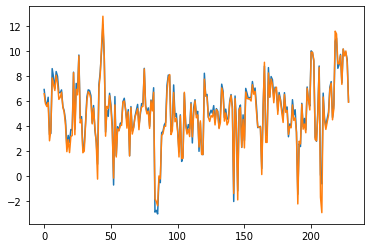

In [115]:
plt.plot(trainy_pred[:,0])
plt.plot(Y_train[:,0])

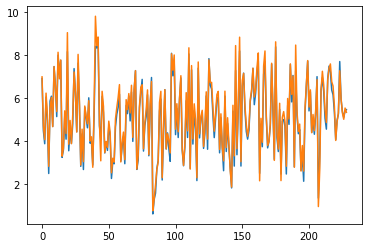

In [117]:
plt.plot(trainy_pred[:,1])
plt.plot(Y_train[:,1])

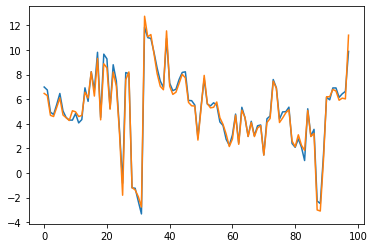

In [116]:
plt.plot(testy_pred[:,0])
plt.plot(Y_test[:,0])

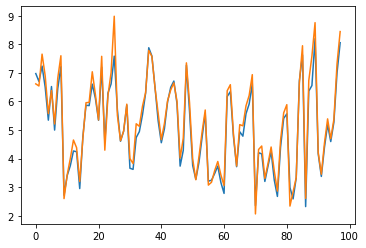

In [118]:
plt.plot(testy_pred[:,1])
plt.plot(Y_test[:,1])

# Evaluation

In [120]:
#encoding=utf-8
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np


# 计算RMSE
def calcRMSE(true,pred):
    return np.sqrt(mean_squared_error(true, pred))


# 计算MAE
def calcMAE(true,pred):
    return mean_absolute_error(true, pred)


# 计算MAPE
def calcMAPE(true, pred, epsion = 0.0000000):

    true += epsion
    return np.mean(np.abs((true-pred)/true))*100


# 计算SMAPE
def calcSMAPE(true, pred):
    delim = (np.abs(true)+np.abs(pred))/2.0
    return np.mean(np.abs((true-pred)/delim))*100

In [130]:
print(calcRMSE(Y_train, trainy_pred))
print(calcRMSE(Y_test, testy_pred))

0.3437374
0.3446669


In [129]:
print(calcRMSE(Y_train, trainy_pred_lstm))
print(calcRMSE(Y_test, testy_pred_lstm))

0.26651198
0.3147586
